## W207 Final Project - House Price Prediction

In this project, we will participate in the Kaggle competition - House Price Prediction. This data has 79 features (43 categorical, 36 numeric). Each of these 79 variables specifies the quality and quantity of physical attributes of a house. The training dataset size: 1,460 observations and the test dataset size: 1,459 observations. Our goal is to predict the sale price of each home in Ames, Iowa, from 2006 to 2010 in the test dataset. 

by Robert Hosbach, Eric Liu, Aishah Newson, and Frankie Pun

8/4/2021




In [ ]:
# To install pandas-profiling package (if necessary)
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
from datetime import datetime
import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten
from keras.models import Sequential

import tensorflow

from pandas_profiling import ProfileReport
# from google.colab import files

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# comment out the following line will hide the graphs
#%matplotlib inline

# Read Data

In [ ]:
# Read in the training and test data
train = pd.read_csv("https://raw.githubusercontent.com/frankiepun/w207-kaggle/master/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/frankiepun/w207-kaggle/master/house-prices-advanced-regression-techniques/test.csv")
test_id = test["Id"].copy() # keep a copy of test's ID column
# Drop the ID column from training and test data
train.drop("Id", inplace=True, axis=1)
test.drop("Id", inplace=True, axis=1)
Y = np.log(train['SalePrice']) # Log-transform SalePrice (error is calculated on log values)

# set random seeds for reproducibility
np.random.seed(0)
tensorflow.random.set_seed(0)


# Exploratory Data Analysis


##Data profile for all features

To see the data distribution for each feature, please click on the link below. It has all the core statistics information such as the number of distinct values, number of missing values, minimum, maximum, number of zeros, number of negatives, and many more.

[Data Profile for all features](https://htmlpreview.github.io/?https://raw.githubusercontent.com/frankiepun/w207-kaggle/master/kaggle%20house%20price%20prediction%20features%20profile.html)

In [ ]:
# Note that the following EDA profile takes over 2 minutes to generate
def generate_features_profile():
  """Function to generate html files containing profiles of the
  training and test data sets for EDA purposes."""

  # Create and save training profile to an html file
  train_profile = ProfileReport(
      train,
      minimal=True,
      title="Training Data Report",
      html={"style": {"full_width": True}})
  train_profile.to_file(output_file="train_profile.html")
  #files.download("train_profile.html")

  # Create and save test profile to an html file
  test_profile = ProfileReport(
      test,
      minimal=True,
      title="Test Data Report",
      html={"style": {"full_width": True}})
  test_profile.to_file(output_file="test_profile.html")
  #files.download("test_profile.html")

  # Create and save combined profile to an html file
  combined_df = pd.concat([train, test], axis=0).reset_index(drop=True).copy()  # combined.shape=(2919, 80)
  combined_profile = ProfileReport(
      combined_df,
      minimal=True,
      title="Combined Test and Training Data Report",
      html={"style": {"full_width": True}})
  combined_profile.to_file(output_file="combined_profile.html")
  #files.download("combined_profile.html")

#generate_features_profile()

## Data Distribution of SalePrice

[Histograms of SalePrice](https://htmlpreview.github.io/?https://raw.githubusercontent.com/frankiepun/w207-kaggle/master/saleprice.html)


In [ ]:
# Looking at SalePrice variable
# SalePrice data is right-skewed with a long tail. Applying Logarithm will make it more normal
# To see the charts, click on the link above or comment out #%matplotlib inline
def sale_price_distribution():
  ''' this function plots histograms for SalePrice '''
  fig, axs = plt.subplots(ncols=2) # Create figure and two subplots
  fig.set_size_inches(12, 4) # Set figure size
  sns.histplot(data=train, x='SalePrice', ax=axs[0]).set_title('SalePrice Histogram') # First histogram of SalePrice
  axs[0].set_xlabel("SalePrice [$]")
  sns.histplot(Y, ax=axs[1]).set_title('Logarithm SalePrice Histogram') # Second histogram of ln(SalePrice)
  axs[0].set_xlabel("Ln(SalePrice)")

sale_price_distribution()


## Plot numerical features vs SalePrice

[See the scatterplots of numerical features vs SalePrice](https://htmlpreview.github.io/?https://raw.githubusercontent.com/frankiepun/w207-kaggle/master/numerical.html)

In [ ]:
# To see the charts, click on the link above or comment out #%matplotlib inline
def numerical_vs_saleprice():
  """Function to plot scatterplots for all numerical features vs.
  SalePrice."""

  # Get list of numerical features, excluding SalePrice
  numerical_features = [feature for feature in train.columns if (train[feature].dtype != 'O') and
                        (feature != 'SalePrice')]

  fig, axs = plt.subplots(nrows=len(numerical_features)) # Create figure and subplots
  fig.set_size_inches(10, 6*len(numerical_features)) # Set figure size
  for i,feature_name in enumerate(numerical_features): # Iterate through features for plotting
    sns.scatterplot(x=feature_name, y='SalePrice', data=train, ax=axs[i]) # Generate scatterplot
    axs[i].title.set_text(f"{feature_name} vs SalePrice") # Set title for each subplot

 
numerical_vs_saleprice()

## Plot categorical features vs SalePrice

[See the boxplots of categorical features vs SalePrice](https://htmlpreview.github.io/?https://raw.githubusercontent.com/frankiepun/w207-kaggle/master/categorical.html)

In [ ]:
# To see the charts, click on the link above or comment out #%matplotlib inline
def categorical_vs_saleprice():
  '''Function to plot boxplots for all non-numeric features vs. SalePrice.'''

  categorical_features = [feature for feature in train.columns if train[feature].dtype == 'O']
  train_categorical = train[categorical_features]
  train_categorical["SalePrice"] = train["SalePrice"]
  train_categorical.fillna("NA", inplace=True)

  fig, axs = plt.subplots(nrows=len(categorical_features)) # Create figure and subplots
  fig.set_size_inches(10, 6*len(categorical_features)) # Set figure size
  for i,feature_name in enumerate(categorical_features): # Iterate through features for plotting
    sns.boxplot(x=feature_name, y="SalePrice", data=train_categorical, ax=axs[i]) # Generate boxplot
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90) # Rotate tick labels for easier viewing
    axs[i].title.set_text(f"{feature_name} vs SalePrice") # Set title for each subplot

    
categorical_vs_saleprice()

# Handle Missing Values for Categorical and Numeric Variables

It is easier to apply the same data processing to both train and test data. So we first combine them. 

In [ ]:
def combine_train_test():
  """Function to combine train and test data for further
  data processing."""

  combined = pd.concat([train, test], axis=0).reset_index(drop=True).copy() # combined.shape=(2919, 80)

  nan_column_list = combined.isnull().any() # Get list of columns that have missing values

  #print(nan_column_list[nan_column_list].index.tolist())
  #print(len(nan_column_list[nan_column_list].index.tolist()))
  # The following features have missing values
  # NaN columns = ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
  # 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
  # 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
  # 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SalePrice']

  # combined_nan = combined[combined.columns[nan_column_list]] # Create dataframe that with only columns having NaN values

  # print("The nummber of NaN in each columns")
  # print(combined_nan.isnull().sum())

  return combined

# combining train and test. combined.shape=(2919, 68), No ID and SalePrice
combined = combine_train_test()

In [ ]:
def handle_nan(df):
  """Function to perform data imputation and other minor data transformations."""

  df = df.copy()

  # Drop extraneous columns - they have low variance or a large number of NAs
  # LotFrontage is a numeric column - There are 486 NaN. Drop the column
  # Alley - Gravel/Paved alley access 90+% of the data is NaN. Drop the column
  # Utilities - 99.9% of the data is AllPub. Data is not diverse. Drop the column
  # MasVnrArea is a numeric column. Most of them are zero. There are 23 NAs. Drop the column
  # GarageYrBlt - numeric value. There are 159 NaN. Drop this column
  # PoolQC - over 99% is NA. Drop the column
  # Fence - over 80% is NA. Drop the column
  # MiscFeature - over 90% is NA. Drop the column
  # LandSlope. 95% is Gtl. Drop the column
  # Condition2. 99% is Norm. Drop the column
  # RoofMatl. 98% is CompShg. Drop the column
  # Heating. 98% is GasA. Drop the column
  to_drop = ["LotFrontage", "Alley", "Utilities", "MasVnrArea", "GarageYrBlt", "PoolQC", "Fence", 
             "MiscFeature", 'LandSlope', 'Condition2', 'RoofMatl', 'Heating']
  df.drop(columns=to_drop, inplace=True)

  # Log-transform LotArea to make it normal
  df["LotArea"] = np.log(df["LotArea"])

  # Fill with specific values
  # MasVnrType's NaN data distribution is similar to BrkFace (Brick Face). Set it to BrkFace
  df["MasVnrType"].fillna("BrkFace", inplace=True)
  # BsmtFullBath - keep the column. Data is diverse. Only 2 NA. Set it to 1 Bath
  df["BsmtFullBath"].fillna(1, inplace=True)

  # Fill with "Fa" - NaN data distribution is similar to Fa or Fair
  to_fa = ["BsmtQual", "BsmtCond", "GarageQual", "GarageCond", "SaleType"]

  # Fill with "My_NA"
  to_myna = ["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish"]

  # Fill with 0 
  # These four columns have only one observation with missing data in test data. That house is a small house.
  to_zero = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]

  # Fill with mode (the most frequent)
  to_mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Electrical", "BsmtHalfBath", "KitchenQual", "Functional", "GarageCars", "Street"]

  # Fill with mean - Only one observation with NA. We will fill it with the mean of GarageArea
  to_mean = ["GarageArea"]

  # A ColumnTransformer takes in a list, which contains tuples of the transformations we wish to perform on the different columns. 
  # Each tuple expects 3 comma-separated values: 
  # first, the name of the transformer, which can be practically anything (passed as a string), 
  # second is the estimator object, and 
  # the final one being the columns upon which we wish to perform that operation.
  # remainder="passthrough" for retaining "unused" columns
  processor = ColumnTransformer(
      remainder = "passthrough",
      transformers=[
        ("mode", SimpleImputer(strategy="most_frequent"), to_mode),
        ("mean", SimpleImputer(strategy="mean"), to_mean),
        ("fa", SimpleImputer(strategy="constant", fill_value="Fa"), to_fa),
        ("myna", SimpleImputer(strategy="constant", fill_value="My_NA"), to_myna),
        ("zero", SimpleImputer(strategy="constant", fill_value=0), to_zero)])

  # Fit the ColumnTransformer and transform our original data frame
  imputed = processor.fit_transform(df)

  # Converts the resulting numpy array back to pandas 
  # The column order gets rearranged by ColumnTransformer; the following lines
  # allow for getting back to the normal order (was used to verify ColumnTransformer worked as expected)
  other_cols = list(df.columns)
  for used in (to_mode + to_mean + to_fa + to_myna + to_zero):
    # Remove all columns that were explicitly filled using the ColumnTransformer
    other_cols.remove(used)
  # Convert the np array back into a dataframe, with the correct column names
  new_df = pd.DataFrame(imputed, columns=to_mode + to_mean + to_fa + to_myna + to_zero + other_cols)

  # ColumnTransformer converts the type to object. This function infers the type properly
  new_df = new_df.infer_objects()
  return new_df  

combined = handle_nan(combined)
#print("The nummber of NaN in each columns")
#print(combined.isnull().sum().sort_values(ascending=False))

The following columns are some special conditions

There is data inconsistency between YearBuilt and YearRemodAdd. YearRemodelAdd is earlier than YearBuilt for one record; however, fixing the data actually hurts the performance and therefore, we decided to keep the column as is.

In [ ]:
# data inconsistency in YearBuilt earlier than YearRemodAdd. However, we find that it doesn't help the
# performance. So we decided not to correct it.

def bad_year_built():
  """Function to add new columns for home age and years since a remodel occurred."""

  # Sanity checks on how YearBuilt compares to YearRemodAdd
  same = (combined["YearBuilt"] == combined["YearRemodAdd"]).sum()
  later = (combined["YearBuilt"] < combined["YearRemodAdd"]).sum()
  earlier = (combined["YearBuilt"] > combined["YearRemodAdd"]).sum()
  print(f"                             Total rows = {combined.shape[0]}")
  print(f"     Remodel year is same as built year = {same}")
  print(f"  Remodel year is later than built year = {later}")
  print(f"Remodel year is earlier than built year = {earlier}")

  # Correct mistaken remodel before built
  for index, row in combined.iterrows():
      if row['YearRemodAdd'] < row['YearBuilt']:
          combined.at[index, 'YearRemodAdd'] = test.at[index, 'YearBuilt']
  # Check if mistake still exists
  for index, row in combined.iterrows():
      if row['YearRemodAdd'] < row['YearBuilt']:
          print(row['YearRemodAdd'])
          print(row['YearBuilt'])

  # Adding home_age and remodel_age
  combined['home_age'] = combined['YrSold'] - combined['YearBuilt']
  combined['remodel_age'] = combined['YrSold'] - combined['YearRemodAdd']
  print(combined.columns)    

# Features Selection

We tried three methods to select features

1) PCA - we tried different n components but we didn't get good results. Also, the PCA features are no longer intuitive, human-readable features. As a result, we decided not to use PCA in this project.

2) Lasso - it applies regularization to avoid learning very large weights by adding a penalty. It yields a sparse model with zero coefficients. This method reduces the 79 features to 37 features.

3) Hand pick - This approach gives us the most flexibility. We can add, drop, or combine features based on EDA analysis.


### Convert categorical to numerical features

Instead of one-hot encoding, we convert the categorical values to ordinal numerical values by the mean(SalePrice) on the feature's values. For example, if a value of feature has higher mean(SalePrice), we assign a lower value. We then apply StandardScaler to standardize the values. We compared MinMaxScaler and StandardScaler and found the StandardScaler yields better results. 

In [ ]:
def convert_categorical_to_numeric_values(combined_df):
  '''
  Converts the categorical values in combined_df to ordinal numerical values.
  It first groups by feature values to calculate the mean of SalePrice and then assign a rank to it;
  then it uses StandardScaler to convert them to standard normal distribution with zero mean.
  :param combined_df: contains features + SalPrice and train/test combined
  :return: dataframe with all numeric values
  Note: some code is based on Krish Naik's video (Naik 2020) 
  '''
  categorical_features = [feature for feature in combined_df.columns if combined_df[feature].dtype == 'O']

  # Example House Condition is a categorical value
  # Example: House Condition has three values: excellent, average, poor
  # let's say mean(SalePrice) group by excellent = 100,000
  #   average - mean(SalePrice) group by average = 50,000
  #   poor - mean(SalePrice) group by by poor = 30,000
  # We then order them. In this case, we will assign excellent -> 1, average -> 2, poor -> 3
  # Apply Scaler -> 1, 2, 3 to standardize to mean 0
  for feature in categorical_features:
    labels_ordered = combined_df.groupby([feature])['SalePrice'].mean().sort_values().index
    labels_ordered = {k:i for i,k in enumerate(labels_ordered, 0)}
    combined_df[feature] = combined_df[feature].map(labels_ordered)

  # remove SalePrice
  feature_scale=[feature for feature in combined_df.columns if feature not in ['SalePrice']]

  # all categorical values will be standardized to standard normal distribution with zero mean
  # convert categorical features to numerical numbers by ranking them based on the mean of SalePrice
  # Use StandardScaler to standardize the value range and the mean is zero
  scaler = StandardScaler() # Initialize StandardScaler object
  combined_transformed = scaler.fit_transform(combined_df[feature_scale]) # Fit scaler on and transform the data
  combined = pd.DataFrame(combined_transformed, columns=feature_scale) # Convert back into dataframe
  return combined

combined = convert_categorical_to_numeric_values(combined)

## Select features by PCA

In [ ]:
def select_feature_by_PCA(n, combined_df):
  '''
  It reduces the features in combined_df to n features using PCA.
  :return: X_train, X_dev, y_train, y_dev, test_after_eda, all with only n features
  '''
  pca = PCA(n_components=n) # Initialize PCA object
  pca_data = pca.fit_transform(combined_df) # Fit PCA object on and transform data
  sum_explained_variance = np.sum(pca.explained_variance_ratio_) # Determine how much variance is captured by the principal components
  print(f"Explained variance: {sum_explained_variance}")

  # Let's print some stats:
  print(f"total features: {combined_df.shape[1]}")
  print(f"# of selected features: {pca_data.shape[1]}")

  # Convert the data back into a dataframe.
  pca_df = pd.DataFrame(pca_data)
  #print(pca_df)

  X = pca_df[:len(Y)] # Pull out just the training data
  # Break the training data into training and dev sets, with 25% of records in the dev set
  X_train_train, X_train_dev, y_train_train, y_train_dev = train_test_split(X, Y, random_state=77, test_size=0.25)
  test_after_eda = pca_df[len(Y):] # Pull out just the test data

  return X, X_train_train, X_train_dev, y_train_train, y_train_dev, test_after_eda # Return transformed data sets


In [ ]:
def PCA_test():
  """Function to determine the optimal number of principal components from PCA."""

  k_array = range(len(combined.columns)) # Initialize array up to number of columns
  train = combined[:len(Y)] # Get training data
  variance_array = [] # Initialize blank list for storing explained variances
  for k in k_array: # For each number of principal components...
      pca = PCA(n_components=k) # Initialize PCA object
      pca.fit(train) # Fit the PCA object on the data
      variance_frac = sum(pca.explained_variance_ratio_) # Calculate the total explained variance by the principal components
      print(f"k = {k}, fraction of total variance explained = {variance_frac}") # Print it out
      variance_array.append(variance_frac) # Append total explained variance to `variance_array`

  # Generate plot of explained variance as a function of the number of principal components
  plt.plot(k_array, variance_array) # Create plot
  # Add title and x and y axis labels
  plt.title("Fraction of total variance vs. number of principal components")
  plt.xlabel("Number of principal components")
  plt.ylabel("Fraction of total variance")
    
#PCA_test()

## Select features by lasso

Lasso regression can be used for features selection. The idea of Lasso is to optimize the cost function by reducing the absolute values of coefficients. If the coefficient of a feature becomes zero, we can drop the feature. (Gianluca 2021, Naik 2020)

In [ ]:
def select_feature_by_lasso(combined_df):
  '''
  It uses Lasso regression model to select the significant features.
  The higher the alpha, the less features that will be selected.
  :param combined_df: combined dataframe of Train and Test
  :return: X_train, X_dev, y_train, y_dev, test_after_eda, all with only a subset of features
  '''

  train_after_eda = combined_df[:len(Y)] # Get just the training data
  feature_sel_model = SelectFromModel(Lasso(alpha=0.001, random_state=0))  # Remember to set the seed, the random state in this function
  feature_sel_model.fit(train_after_eda, Y) # Fit the SelectFromModel() object
  # print(feature_sel_model.get_support())

  # lasso uses L1 regularization which reduces some weights to zero, which means drop the columns
  # get_support() contains True/False of each feature. We only select features with get_support() == True
  selected_feat = train_after_eda.columns[(feature_sel_model.get_support())]

  # Let's print some stats:
  print(f"total features: {train_after_eda.shape[1]}")
  print(f"# of selected features: {len(selected_feat)}")
  print(f"selected features: {selected_feat}")

  # Break the training data into training and dev sets, with 25% of records in the dev set
  X_train_train, X_train_dev, y_train_train, y_train_dev = train_test_split(train_after_eda, Y, random_state=77, test_size=0.25)
  test_after_eda = combined_df[len(Y):]  # Pull out just the test set

  # Limit to just the columns left after Lasso
  X_train_train = X_train_train[selected_feat]
  X_train_dev = X_train_dev[selected_feat]
  test_after_eda = test_after_eda[selected_feat]
  X = train_after_eda[selected_feat]
  
  return X, X_train_train, X_train_dev, y_train_train, y_train_dev, test_after_eda

## Select features by hand

This function allow us to select the features by hand. It provides the flexibility for adding or removing features easily.

In [ ]:
def select_feature_by_hand(combined_df):
  '''
  Select features manually.
  '''

  # Derive a new field by using FullBath and HalfBath
  combined_df['total_bath'] = combined_df['FullBath'] + (0.5 * combined_df['HalfBath'])

  # 'Condition1' - low variance but keeping it yields better accuracy
  selected_features = ['MSSubClass', 'MSZoning', 'LotArea', 'LotConfig',
                        'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                        'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
                        'YearRemodAdd', 'BsmtFullBath', 'BsmtQual', 'TotalBsmtSF',
                        '1stFlrSF', 'GrLivArea', 'total_bath',
                        'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
                        'GarageType', 'GarageFinish', 'GarageCars', 'GarageCond',
                        'PavedDrive', 'ScreenPorch', 'YrSold', 'SaleCondition']

  train_after_eda = combined_df[:len(Y)] # Get just the training data

  # Let's print some stats:
  print(f"total features: {train_after_eda.shape[1]}")
  print(f"# of selected features: {len(selected_features)}")
  print(f"selected features: {selected_features}")

  # Break the training data into training and dev sets, with 25% of records in the dev set
  X_train_train, X_train_dev, y_train_train, y_train_dev = train_test_split(train_after_eda, Y, random_state=77, 
                                                                            test_size=0.25)
  test_after_eda = combined_df[len(Y):] # Pull out just the test set

  # Limit to just the manually selected columns
  X_train_train = X_train_train[selected_features]
  X_train_dev = X_train_dev[selected_features]
  test_after_eda = test_after_eda[selected_features]
  X = train_after_eda[selected_features]
  
  return X, X_train_train, X_train_dev, y_train_train, y_train_dev, test_after_eda

## Remove outliers

There are only two houses' SalePrice over 600K. Originally, we wanted to remove it but keeping it generates better results.

In [ ]:
# Removing outliers doesn't help.
def remove_outliers(X, Y, X_train_train, X_train_dev, y_train_train, y_train_dev):
  """Function to remove outlying values."""
   
  # There are four houses with significantly higher SalePrice.
  # From the SalesPrice distribution, the cut off point is 600,000
  print(X.shape)
  log_600k = np.log(600000)
  # Filter out the outliers from X and Y
  X = X.drop(Y[Y > log_600k].index, axis=0)
  Y = Y.drop(Y[Y > log_600k].index, axis=0)
  X_train_train = X_train_train.drop(y_train_train[y_train_train > log_600k].index, axis=0)
  y_train_train = y_train_train.drop(y_train_train[y_train_train > log_600k].index, axis=0)
  X_train_dev = X_train_dev.drop(y_train_dev[y_train_dev > log_600k].index, axis=0)
  y_train_dev = y_train_dev.drop(y_train_dev[y_train_dev > log_600k].index, axis=0)

  return X, Y, X_train_train, X_train_dev, y_train_train, y_train_dev

## Select features and split the training dataset to train_train and train_dev

We split the training dataset to train and dev and save the dev dataset for validation. 

In [ ]:
# X, X_train_train, X_train_dev, y_train_train, y_train_dev, test = select_feature_by_PCA(32, combined)
#X, X_train_train, X_train_dev, y_train_train, y_train_dev, test = select_feature_by_lasso(combined)
X, X_train_train, X_train_dev, y_train_train, y_train_dev, test = select_feature_by_hand(combined)

# Removing outliers does't help. Do not call.
# X, Y, X_train_train, X_train_dev, y_train_train, y_train_dev = remove_outliers(X, Y, X_train_train, X_train_dev, y_train_train, y_train_dev)

print(f"X             shape: {X.shape}")
print(f"Y             shape: {Y.shape}")
print(f"X_train_train shape: {X_train_train.shape}")
print(f"y_train_train shape: {y_train_train.shape}")
print(f"  X_train_dev shape: {X_train_dev.shape}")
print(f"  y_train_dev shape: {y_train_dev.shape}")
print(f"   test shape: {test.shape}")
print()

total features: 68
# of selected features: 31
selected features: ['MSSubClass', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'YearRemodAdd', 'BsmtFullBath', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'total_bath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageCond', 'PavedDrive', 'ScreenPorch', 'YrSold', 'SaleCondition']
X             shape: (1460, 31)
Y             shape: (1460,)
X_train_train shape: (1095, 31)
y_train_train shape: (1095,)
  X_train_dev shape: (365, 31)
  y_train_dev shape: (365,)
   test shape: (1459, 31)



## Data sanity check

Check if Test and Train datasets have the same number of features. We originally split Train dataset to dev/train but we decided to use KFolds which utilizes the entire Train dataset.

In [ ]:
# Sanity check - the # of NaN columns X_train and X_dev dataset match
matched_train_dev = all(
    X_train_train[X_train_train.columns[~X_train_train.isnull().any()]].columns == X_train_dev[X_train_dev.columns[~X_train_dev.isnull().any()]].columns
    )
if matched_train_dev == False:
    print("X_train_train's columns and X_train_dev's columns don't match")

# Sanity check - the # of NaN columns test and train dataset match
matched_train_test = all(
    X_train_train[X_train_train.columns[~X_train_train.isnull().any()]].columns == test[test.columns[~test.isnull().any()]].columns
    )
if matched_train_test == False:
    print("X_train_train's columns and test's columns don't match")


# Combine Model Predictions into Ensemble


## Create K-fold cross validation

In [ ]:
# Use KFold cross-validation to train the model
kfolds = KFold(n_splits=10, shuffle=True, random_state=42) # Create KFold() object with 10 splits

def cv_rmse(model, x_data, y_data):
  '''
  Calculate the cross validation score of the model, given X.
  The cross validation method is kfolds
  :param model: passed in model
  :param X: training dataset
  :return:
  '''
  rmse = np.sqrt(-cross_val_score(model, x_data, y_data, scoring="neg_mean_squared_error", cv=kfolds))
  return (rmse)


# Some parameters for tuning:
alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5] # Used for RidgeCV
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008] # Used for LassoCV
alphas_enet = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007] # Used for ElasticNetCV
l1ratios_enet = [0.8, 0.85, 0.9, 0.95, 0.99, 1] # Used for ElasticNetCV

## Create neural network

We created a neural network with 3 hidden layers and 256 nodes

In [ ]:
# Create Neural Network
# Some of the following code is based on "House Prices Advanced Regression Techniques", Nanashi (2019)
def create_neural_network(num_features):
  """Function to create a neural network with an input layer, 3 hidden layers, and an output layer."""

  NN_model = Sequential() # Create NN object

  # Add the input layer with 128 units (i.e., dimensionality of output space from layer)
  NN_model.add(Dense(128, kernel_initializer='normal', input_dim=num_features, activation='relu'))

  # Add the hidden layers, each with 256 units
#   NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#   NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#   NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

  NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
  NN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))
  NN_model.add(Dense(64, kernel_initializer='normal', activation='relu'))

  # Add the output layer with 1 unit
  NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Compile the network
  NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
  # NN_model.summary()

  return NN_model

def cv_rmse_nn(nn, x_data, y_data):
  '''
  This function calculates the RMSE of neural network. Neural network is not part of
  sklearn package. We must iterate kfolds to measure the performance
  '''
  cvscores = []
  for some_train, some_test in kfolds.split(x_data, y_data): # Iterate through splits
      nn.fit(x_data.iloc[some_train, :], y_data.iloc[some_train], epochs=50, batch_size=32, verbose=0) # Fit the NN model
      scores = nn.evaluate(x_data.iloc[some_test, :], y_data.iloc[some_test], verbose=0) # Get model score
      cvscores.append(scores[1]) # Append CV score to cvscores

  print("NN: {:.4f} ({:.4f})\n".format(np.sqrt(np.mean(cvscores)), np.sqrt(np.std(cvscores))), datetime.now(), )

## Create the ensemble model

This class creates an ensemble model which consists of the following models:
ridge, lasso, elasticnet, svr, gbr, lightgbm, xgboost, random forest, and neural network. We tried to add K-Nearest Neighbor Regression but it results in poorer accuracy.


*   Ridge - This model solves a regression model where the loss function is the linear least squares function and regularization is given by the L2-norm. 
*   Lasso - Linear Model trained with L1 prior as regularizer
*   Elasticnet - Linear regression with combined L1 and L2 priors as regularizer.
*   SVR - Epsilon-Support Vector Regression
*   GBR - Gradient Boosting for regression. GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.
*   Lightgbm - a gradient boosting framework that uses tree based learning algorithms.
*   Xgboost - an optimized gradient boosting library 
*   Random Forest - a random regression forest is an ensemble of randomized regression trees
*   K-Nearest Neighbor Regression - approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.
*   Neural Network

We then use Stacking, an ensemble learning technique, to combine some of the above regression models via a meta-regressor. Finally, the prediction is based on weighted average of the above models and stacking models. 


We set some of the initial parameters and hyperparameters by referencing this article: House Prices: Advanced Regression Techniques (Nanshai 2019).

In [ ]:
class EnsembleModel():
  '''
  This class creates an ensemble model which consists of the following models:
  ridge, lasso, elasticnet, svr, gbr, lightgbm, xgboost, random forest, and neural network.
  - create_several_models() instantiates the models with kfolds cross-validation
  - calculate_cross_validation_rmse() - calculates RMSE based on cross-validation
  - fit() - fit the model with X and Y
  - predict() - use the model to predict Y
  - generate_submission_csv() - generate a file for kaggle submission
  - save_models_to_file() - saves the models to the file system
  - load_models_from_file() - loads the model from the file system
  '''

  def create_several_models(self, x_data): # x_data is needed for neural network only
      '''
      It creates the following models: ridge, lasso, elasticnet, svr, gbr, lightgbm, 
      xgboost, random forest, and neural network.
      :param x_data: it is used by NN network only. It needs the # of features for the input layer 
      :return: None
      '''
      self.ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds)) # Create RidgeCV() object
      self.lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas_lasso, random_state=42, cv=kfolds)) # Create LassoCV() object
      self.elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=alphas_enet, cv=kfolds, l1_ratio=l1ratios_enet, random_state=42)) # Create ElasticNetCV() object
      self.svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003)) # Create SVR() object
      self.gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15,
                                            min_samples_split=10, loss='huber', random_state=42) # Create GradientBoostingRegressor() object
      self.lightgbm = LGBMRegressor(num_leaves=4,
                                learning_rate=0.01,
                                n_estimators=5000,
                                max_bin=200,
                                bagging_fraction=0.75,
                                bagging_freq=5,
                                bagging_seed=7,
                                feature_fraction=0.2,
                                feature_fraction_seed=7,
                                verbose=-1,
                                random_state=77
                                ) # Create LGBMRegressor() object
      self.xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                              max_depth=3, min_child_weight=0,
                              gamma=0, subsample=0.7,
                              colsample_bytree=0.7,
                              objective="reg:squarederror", nthread=-1,
                              scale_pos_weight=1, seed=27,
                              random_state=77,
                              reg_alpha=0.00006) # Create XGBRegressor() object
      self.rfr = RandomForestRegressor(random_state=77) # Create RandomForestRegressor() object
      self.nn = create_neural_network(x_data.shape[1]) # Create neural network
      self.knn = KNeighborsRegressor(n_neighbors=10) # Create KNEighborsRegressor() object

      # Create model object that stacks individual models and evaluates using CV
      self.stack_gen = StackingCVRegressor(
        regressors=(self.rfr, self.ridge, self.lasso, self.elasticnet,
                    self.gbr, self.xgboost, self.lightgbm),
        meta_regressor=self.xgboost,
        use_features_in_secondary=True)

  def calculate_cross_validation_rmse(self, x_data, y_data):
    '''
    It uses K-fold cross-validation to split the x_data & y_data to calculate the RMSE
    :param x_data: X data
    :param y_data: Y data
    :return: None
    '''

    # Get and print scores for each individual model
    score = cv_rmse(self.rfr, x_data, y_data)
    print("RandomForest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    cv_rmse_nn(self.nn, x_data, y_data)  # calculate the root mean squared error of neural network using KFold

    #score = cv_rmse(self.knn, x_data, y_data)
    #print("KNN: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


    score = cv_rmse(self.ridge, x_data, y_data)
    print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    score = cv_rmse(self.lasso, x_data, y_data)
    print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    score = cv_rmse(self.elasticnet, x_data, y_data)
    print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    score = cv_rmse(self.svr, x_data, y_data)
    print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    score = cv_rmse(self.lightgbm, x_data, y_data)
    print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    score = cv_rmse(self.gbr, x_data, y_data)
    print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

    score = cv_rmse(self.xgboost, x_data, y_data)
    print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

  def fit(self, x_data, y_data):
    '''
    Fit the model with data
    :param x_data: x data
    :param y_data: y data
    :return: None
    '''

    # Fit each of the models to the data
    print('fitting stack_gen')
    self.stack_gen_model_fitted = self.stack_gen.fit(np.array(x_data), np.array(y_data))

    print("fitting random_forest")
    self.rfr_model_full_data_fitted = self.rfr.fit(x_data, y_data)

    #print("fitting KNN")
    #self.knn_model_full_data_fitted = self.knn.fit(x_data, y_data)

    print('fitting elasticnet')
    self.elastic_model_full_data_fitted = self.elasticnet.fit(x_data, y_data)

    print("fitting neural network")
    self.nn.fit(x_data, y_data, epochs=50, batch_size=32, verbose=0)

    print('fitting lasso')
    self.lasso_model_full_data_fitted = self.lasso.fit(x_data, y_data)

    print('fitting ridge')
    self.ridge_model_full_data_fitted = self.ridge.fit(x_data, y_data)

    print('fitting SVR')
    self.svr_model_full_data_fitted = self.svr.fit(x_data, y_data)

    print('fitting gradient boosting')
    self.gbr_model_full_data_fitted = self.gbr.fit(x_data, y_data)

    print('fitting xgboost')
    self.xgb_model_full_data_fitted = self.xgboost.fit(x_data, y_data)

    print('fitting lightgbm')
    self.lgb_model_full_data_fitted = self.lightgbm.fit(x_data, y_data)


  def predict(self, x_data):
    '''
    Use the model to predict y based on x_data
    :param x_data: X
    :return: an np array predicted Y 
    '''

    # Get predictions from each model, as well as the stacked model,
    # and apply custom weights to each of the models to generate a
    # weighted average predicted log(SalePrice) for each home.
    return ((0.05 * self.elastic_model_full_data_fitted.predict(x_data)) +
            (0.05 * self.rfr_model_full_data_fitted.predict(x_data)) +
            (0.05 * self.nn.predict(x_data).flatten()) +
            (0.05 * self.lasso_model_full_data_fitted.predict(x_data)) +
            (0.05 * self.ridge_model_full_data_fitted.predict(x_data)) +
            (0.1 * self.svr_model_full_data_fitted.predict(x_data)) +
            (0.1 * self.gbr_model_full_data_fitted.predict(x_data)) +
            (0.15 * self.xgb_model_full_data_fitted.predict(x_data)) +
            (0.1 * self.lgb_model_full_data_fitted.predict(x_data)) +
            (0.3 * self.stack_gen_model_fitted.predict(np.array(x_data))))

    # return ((0.05 * self.elastic_model_full_data_fitted.predict(x_data)) +
    #         (0.05 * self.rfr_model_full_data_fitted.predict(x_data)) +
    #         (0.05 * self.nn.predict(x_data).flatten()) +
    #         (0.05 * self.lasso_model_full_data_fitted.predict(x_data)) +
    #         (0.05 * self.ridge_model_full_data_fitted.predict(x_data)) +
    #         (0.1 * self.svr_model_full_data_fitted.predict(x_data)) +
    #         (0.1 * self.gbr_model_full_data_fitted.predict(x_data)) +
    #         (0.2 * self.xgb_model_full_data_fitted.predict(x_data)) +
    #         (0.1 * self.lgb_model_full_data_fitted.predict(x_data)) +
    #         (0.25 * self.stack_gen_model_fitted.predict(np.array(x_data))))


  def generate_submission_csv(self, test_data):
    '''
    generate a CSV file called submission.csv for kaggle submission. 
    :param test_data: 
    :return: None
    '''
    y_test_in_logarithm = self.predict(test_data) # Predict house prices for test data
    y_test = np.exp(y_test_in_logarithm) # Reverse logarithm for submission
    # print(y_test)
    # print(y_test.shape)
    my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': y_test})
    # The model tends to underestimate the price. Adjust it by 1% to offset it.
    my_submission['SalePrice'] = my_submission['SalePrice'] * 1.01
    my_submission.to_csv("submission.csv", index=False) # Save csv
    print("Submission CSV is generated.")

  def save_models_to_file(self):
    '''
    Save models to the file system to save time on fitting
    :return: None
    '''
    pickle.dump(self.stack_gen_model_fitted, open('stack_gen_model_fitted.sav', 'wb'))
    pickle.dump(self.rfr_model_full_data_fitted, open('rfr_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.elastic_model_full_data_fitted, open('elastic_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.nn, open('nn_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.lasso_model_full_data_fitted, open('lasso_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.ridge_model_full_data_fitted, open('ridge_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.svr_model_full_data_fitted, open('svr_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.gbr_model_full_data_fitted, open('gbr_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.xgb_model_full_data_fitted, open('xgb_model_full_data_fitted.sav', 'wb'))
    pickle.dump(self.lgb_model_full_data_fitted, open('lgb_model_full_data_fitted.sav', 'wb'))
    print('all models saved')

  def load_models_from_file(self):
    '''
    Load saved models from the file system.
    :return:
    '''
    self.stack_gen_model_fitted = pickle.load(open('stack_gen_model_fitted.sav', 'rb'))
    self.rfr_model_full_data_fitted = pickle.load(open('lgb_model_full_data_fitted.sav', 'rb'))
    self.nn = pickle.load(open('nn_model_full_data_fitted.sav', 'rb'))
    self.elastic_model_full_data_fitted = pickle.load(open('elastic_model_full_data_fitted.sav', 'rb'))
    self.lasso_model_full_data_fitted = pickle.load(open('lasso_model_full_data_fitted.sav', 'rb'))
    self.ridge_model_full_data_fitted = pickle.load(open('ridge_model_full_data_fitted.sav', 'rb'))
    self.svr_model_full_data_fitted = pickle.load(open('svr_model_full_data_fitted.sav', 'rb'))
    self.gbr_model_full_data_fitted = pickle.load(open('gbr_model_full_data_fitted.sav', 'rb'))
    self.xgb_model_full_data_fitted = pickle.load(open('xgb_model_full_data_fitted.sav', 'rb'))
    self.lgb_model_full_data_fitted = pickle.load(open('lgb_model_full_data_fitted.sav', 'rb'))
    print('all models loaded')



## Predict by ensemble models

Kaggle calculates the score using RMSLE (root mean square log error). Our best result is 0.12221 and the rank is 1670.

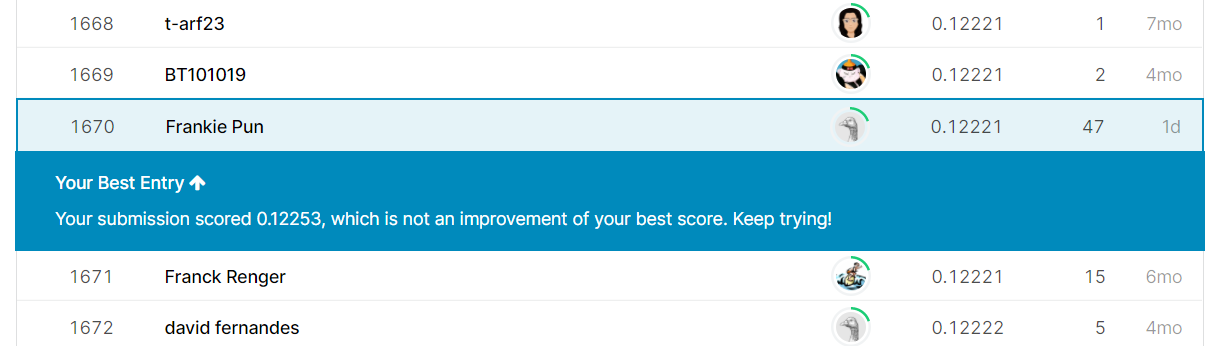

In [ ]:
def create_model_by_full_train_data():
  ''' This function creates the ensemble model with full train data 
  '''
  print("Create the ensemble model with the entire train data")
  print(f"Creation start time: {datetime.now()}")
  # X is 1460
  model = EnsembleModel() # Instantiate EnsembleModel() object
  model.create_several_models(X) # Create several models
  model.calculate_cross_validation_rmse(X, Y) # Evaluate using CV
  model.fit(X, Y) # Fit model
  y_pred = model.predict(X) # Generate predictions
  print('RMSLE score on train data:')
  print(mean_squared_error(Y, y_pred, squared=False)) # Calculate RMSE on training data (should be very low!)

  # generate submission file
  model.generate_submission_csv(test)
  print(f"Creation end time: {datetime.now()}")
 

def create_model_by_subset_train_data():
  ''' this function creates the ensemble model with train/dev data split
  '''
  print("Create the ensemble model with train/dev data split")
  print(f"Creation start time: {datetime.now()}")
  model = EnsembleModel() # Instantiate EnsembleModel() object
  model.create_several_models(X_train_train) # Create several models
  model.calculate_cross_validation_rmse(X_train_train, y_train_train) # Evaluate using CV
  model.fit(X_train_train, y_train_train) # Fit model
  # Use dev data to predict and calculate the RMSLE score
  y_pred = model.predict(X_train_dev)
  print('RMSLE score on train DEV data:')
  print(mean_squared_error(y_train_dev, y_pred, squared=False)) # Calculate RMSE on dev data

  # Generate submission file
  model.generate_submission_csv(test)
  print(f"Creation end time: {datetime.now()}")

create_model_by_full_train_data() #1460 observations
print()
print()
create_model_by_subset_train_data() #1095 observations


Create the ensemble model with the entire train data
Creation start time: 2021-08-02 03:32:29.351606
RandomForest: 0.1394 (0.0228)
 2021-08-02 03:32:40.603463
NN: 0.2050 (0.1998)
 2021-08-02 03:33:28.785177
Ridge: 0.1353 (0.0298)
 2021-08-02 03:33:33.281778
LASSO: 0.1356 (0.0299)
 2021-08-02 03:33:34.373245
elastic net: 0.1356 (0.0299)
 2021-08-02 03:33:37.413981
SVR: 0.1310 (0.0332)
 2021-08-02 03:33:40.038478
lightgbm: 0.1219 (0.0185)
 2021-08-02 03:33:49.796949
gbr: 0.1236 (0.0182)
 2021-08-02 03:35:26.133190
xgboost: 0.1157 (0.0171)
 2021-08-02 03:36:04.551664
fitting stack_gen
fitting random_forest
fitting elasticnet
fitting neural network
fitting lasso
fitting ridge
fitting SVR
fitting gradient boosting
fitting xgboost
fitting lightgbm
RMSLE score on train data:
0.07056734668780665
Submission CSV is generated.
Creation end time: 2021-08-02 03:38:08.645551


Create the ensemble model with train/dev data split
Creation start time: 2021-08-02 03:38:08.672486
RandomForest: 0.1418 (0.

# Reference



* AL-Ma'amari, Mohammaed (2018). Deep Neural Networks for Regression Problems. Captured from https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
* Zaman, Muhammad Imran (2021). House Prices: Detailed EDA and Cross Validation. Captured from https://www.kaggle.com/imranzaman5202/house-prices-detailed-eda-and-cross-validation
* Saxena, Sharoon (2019). What's the Difference Between RMSE and RMSLE. Captured from https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a
* Naik, Krish (2020). Advance House Price Prediction-Feature Engineering Part 2. Captured from https://youtu.be/0fT-bqvHD2w 
* Naik, Krish (2020). Advanced Housing Prices - Feature Engineering. Captured from https://github.com/krishnaik06/Advanced-House-Price-Prediction-/blob/master/Feature%20Engineering.ipynb
* Lafuente, Albert Sanchez (2020). Exploratory Data Analysis with Pandas Profiling. Captured from https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3
* Markham, Kevin (2018). How do I select features for Machine Learning. Captured from https://www.youtube.com/watch?v=YaKMeAlHgqQ&ab_channel=DataSchool
* Patel, Vishal (2017). Feature Reduction Techniques. Captured from https://www.slideshare.net/VishalPatel321/feature-reduction-techniques
* Nanashi (2019). House Prices Advanced Regression Techniques. Captured from https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
* Shivani, Rana (2021) House Price Prediction - Advanced Regression Techniques. Captured from https://www.kaggle.com/shivanirana63/advanced-reg-techniques-eda-feature-eng#3.Model-Building-&-Evaluation
* Anonymous (2021). Prediction using ColumnTransformer, OneHotEncoder and Pipeline. Captured from https://www.geeksforgeeks.org/prediction-using-columntransformer-onehotencoder-and-pipeline/
* Malato, Gianluca (2020). Feature selection in machine learning using Lasso regression. Captured from: https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
